In [678]:
# Include libraries which may use in implementation
import numpy as np
import random
from matplotlib import image as img
import pickle
import glob 
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [679]:
import zipfile
with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [680]:
# Function to load dataset
def loadDataset(path):

    print('Loading Dataset...')
    train_x, train_y, test_x, test_y = [], [], [], []
    for i in range(10):
        for filename in glob.glob(path + '/train/' + str(i)+'/*.png'):

            im=img.imread(filename)
            train_x.append(im)
            train_y.append(i)
    for i in range(10):
        for filename in glob.glob(path + '/test/' + str(i)+'/*.png'):
            im=img.imread(filename)
            test_x.append(im)
            test_y.append(i)
    print('Dataset loaded...')
    return np.array(train_x), np.array(train_y), np.array(test_x),np.array(test_y)

In [681]:
trainX, trainy, testX, testy = loadDataset("/content/dataset/Task3_MNIST_Data")

Loading Dataset...
Dataset loaded...


In [682]:
def shape_label(Y):
    return Y.reshape(Y.shape[0], -1)

In [683]:
trainY = shape_label(trainy)
testY = shape_label(testy)

In [684]:
def meanSubtraction(data):
    mean = np.mean(data, axis = 0)
    plt.imshow(mean.reshape((28,28)))
    return data - mean,mean

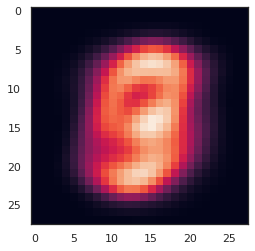

In [685]:
ms_train_set_x,train_mean = meanSubtraction(trainX)
ms_test_set_x = testX- train_mean

In [686]:
# Flattening
Train_set_x_flatten = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
Test_set_x_flatten = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])
Train_ms_set_x_flatten = ms_train_set_x.reshape(ms_train_set_x.shape[0], ms_train_set_x.shape[1] * ms_train_set_x.shape[2])
Test_ms_set_x_flatten = ms_test_set_x.reshape(ms_test_set_x.shape[0], ms_test_set_x.shape[1] * ms_test_set_x.shape[2])

In [687]:
# Create a Neural_Network class
class Neural_Network(object):
    def __init__(self, layers = 2, input_size = 784, no_of_neorons = [128, 64, 10], activation='relu'):  
        # size of layers
        self.layers_size = layers
        self.inputSize = input_size
        self.outputSize = no_of_neorons[-1]
        self.hidden = {}
        for layer in range(self.layers_size):
            if layer != self.layers_size:
                self.hidden["hiddenLayer"+str(layer)+"Size"] = no_of_neorons[layer]
        
        if activation=='sigmoid':
            self.activationFunction = self.sigmoid
            self.activationFunctionDerivative = self.sigmoid_derivative
        if activation=='relu':
            self.activationFunction = self.relu
            self.activationFunctionDerivative = self.reluDerivative
        self.Weights = {}
        self.Z = {}
        self.Y = {}
        self.D = {}
        if self.layers_size > 0:
            for layer in range(self.layers_size):
                if layer == 0:
                    self.Weights[str(layer)] = np.random.rand(self.inputSize + 1, self.hidden["hiddenLayer0Size"])
                else:
                    self.Weights[str(layer)] = np.random.rand(self.hidden["hiddenLayer"+str(layer-1)+"Size"] + 1, self.hidden["hiddenLayer"+str(layer)+"Size"])

            self.Weights[str(self.layers_size)] = np.random.rand(self.hidden["hiddenLayer"+str(self.layers_size - 1)+"Size"] + 1, self.outputSize)
        else:
            self.Weights[str(0)] = np.random.rand(self.inputSize + 1, self.outputSize);
        

    def append_one_to_x(self, X):
        return np.hstack((np.ones((X.shape[0], 1)), X))

    def shape_label(self, Y):
        return Y.reshape(Y.shape[0], -1)
    
    def relu(self, s):
        # activation function
        return np.maximum(0, s) # apply relu function on s and return it's value

    def reluDerivative(self, s):
        s[s<=0] = 0
        s[s>0] = 1
        return s

    def weight_activation(self, _input, _weight):
        return np.dot(self.append_one_to_x(_input), _weight);
    
    def feedforward(self, X):
        for layer in range(self.layers_size):
            if layer == 0:
                self.Z[str(layer)] = self.weight_activation(X, self.Weights[str(layer)])
                self.Y[str(layer)] = self.activationFunction(self.Z[str(layer)])
            else:
                self.Z[str(layer)] = self.weight_activation(self.Y[str(layer-1)], self.Weights[str(layer)])
                self.Y[str(layer)] = self.activationFunction(self.Z[str(layer)])
        self.Z[str(self.layers_size)] = self.weight_activation(self.Y[str(self.layers_size-1)], self.Weights[str(self.layers_size)])
        self.Y[str(self.layers_size)] = self.softmax(self.Z[str(self.layers_size)])                     
        return self.Y[str(self.layers_size)];

    def sigmoid(self, s):
        return 1 / (1 + np.exp(-s));

    def sigmoid_derivative(self, s):
        return s * (1 - s);

    def softmax(self, Z):
        all_exps = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return all_exps / np.sum(all_exps, axis=1, keepdims=True)

    def backwardpropagate(self, X, Y, y_pred, lr):
        if self.layers_size == 0:
            self.D[str(dE_by_dZ0)] = self.crossentropy_softmax_derivative(Y, y_pred)
            self.D[str(dE_by_dY0)] = np.matmul(self.append_one_to_x(X).T, self.D[str(dE_by_dZ0)])
        elif self.layers_size > 0:
            self.D["dE_by_dZ" + str(self.layers_size)] = self.crossentropy_softmax_derivative(Y, y_pred)
            self.D["dE_by_dW" + str(self.layers_size)] = np.matmul(self.append_one_to_x(self.Y[str(self.layers_size-1)]).T, self.D["dE_by_dZ" + str(self.layers_size)])
            for layer in reversed(range(self.layers_size)):
                if layer > 0 and layer < self.layers_size:
                    self.D["dE_by_dY" + str(layer)] = np.matmul(self.D["dE_by_dZ" + str(layer+1)], self.Weights[str(layer+1)].T)
                    self.D["dE_by_dY"+ str(layer)] = self.D["dE_by_dY" + str(layer)][:,:-1]
                    self.D["dY"+str(layer)+"_by_dZ"+str(layer)] = self.activationFunctionDerivative(self.Y[str(layer)])
                    self.D["dE_by_dZ" + str(layer)] =  self.D["dE_by_dY" + str(layer)]*self.D["dY" + str(layer)+"_by_dZ" + str(layer)]
                    self.D["dE_by_dW"+str(layer)] = np.matmul(self.append_one_to_x(self.Y[str(layer-1)]).T, self.D["dE_by_dZ"+str(layer)])
                elif layer == 0:
                    self.D["dE_by_dY" + str(layer)] = np.matmul(self.D["dE_by_dZ" + str(layer+1)], self.Weights[str(layer+1)].T)
                    self.D["dE_by_dY"+ str(layer)] = self.D["dE_by_dY" + str(layer)][:,:-1]
                    self.D["dY"+str(layer)+"_by_dZ"+str(layer)] = self.activationFunctionDerivative(self.Y[str(layer)])
                    self.D["dE_by_dZ" + str(layer)] =  self.D["dE_by_dY" + str(layer)]*self.D["dY" + str(layer)+"_by_dZ" + str(layer)]
                    self.D["dE_by_dW"+str(layer)] =  np.matmul(self.append_one_to_x(X).T, self.D["dE_by_dZ" + str(layer)])            

        for layer in reversed(range(self.layers_size)):
            self.Weights[str(layer)] = self.Weights[str(layer)] - lr * self.D["dE_by_dW"+str(layer)]
        self.Weights[str(self.layers_size)] = self.Weights[str(self.layers_size)] - lr * self.D["dE_by_dW"+str(self.layers_size)]

    def categorical_crossentropy_loss(self, predicted_output, expected_output):
        return -np.mean(expected_output * (np.log(predicted_output+1e-15)))
    
    def crossentropy_softmax_derivative(self, Y, Y_pred):
        return (Y_pred - Y)
    
    def one_hot_encode(self, trainY):
        one_hot_encoded_array = np.zeros(shape=(trainY.shape[0], 10))
        
        for index_num, class_label in enumerate(trainY):
            one_hot_encoded_array[index_num, class_label] = 1
        return one_hot_encoded_array
    
    def train(self, trainX, trainY, testX, testY, epochs = 100, learningRate = 0.001, batch_size = 50):

        
        N = trainX.shape[0]
        training_accuracy = []
        training_loss = []
        valid_accuracy = []
        validation_loss = []
        # One hot encoding
#         y_train_one_hot_encoded = np.zeros(shape=(N, 10))
#         for _index, _class in enumerate(trainY):
#             y_train_one_hot_encoded[_index, _class] = 1
            
            
        trainY_encoded = self.one_hot_encode(trainY)
        testY_encoded = self.one_hot_encode(testY)
        
        
#         y_test_one_hot_encoded = np.zeros(shape=(testX.shape[0], 10))
#         for _index, _class in enumerate(testY):
#             y_test_one_hot_encoded[_index, _class] = 1
        
        # backpropagation with trainX, trainY, predicted value and learning rate.
        for ep in range(epochs):
            random_indexes = np.random.permutation(N)
            loss = 0
            for _start in range(0, N, batch_size):
                mini_batch_indexes = random_indexes[_start : _start + batch_size]
                x_train = trainX[mini_batch_indexes]
                y_train = trainY_encoded[mini_batch_indexes]

                # feed forward trainX and trainY and recivce predicted value
                y_pred = self.feedforward(x_train)  
            
                # backprop and update wieghts
                self.backwardpropagate(x_train, y_train, y_pred, learningRate)
                loss +=self.categorical_crossentropy_loss(y_pred, y_train)
            
            

            training_loss.append(loss/trainX.shape[0])
            _acc = self.accuracy(trainX, trainY)
            training_accuracy.append(_acc)
            
            y_pred = self.feedforward(testX)
            valid_loss = self.categorical_crossentropy_loss(y_pred, testY_encoded)
            valid_acc = self.accuracy(testX, testY)
            valid_accuracy.append(valid_acc)
            validation_loss.append(valid_loss)
            if (ep) % 10 == 0:
                print(ep)
                print(f"training_accuracy = {_acc}, loss = {loss/trainX.shape[0]}")
                print(f"validation_accuracy = {valid_acc}, loss = {valid_loss}")
                print('-------------------------------------------------------------------------------|')
        self.curve_plot(training_loss, training_accuracy, validation_loss, valid_accuracy)
        self.visulize(testY, y_pred)
    
    
    def curve_plot(self, train_loss, train_accuracy, val_loss, val_accuracy):
        # loss curves
        plt.figure(figsize=(8,4))
        plt.title("Training and Validation Loss")
        plt.plot(val_loss,label="val")
        plt.plot(train_loss,label="train")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        # accuracy curves
        plt.figure(figsize=(8,4))
        plt.title("Training and Validation Accuracy")
        plt.plot(val_accuracy,label="val")
        plt.plot(train_accuracy,label="train")
        plt.xlabel("iterations")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
        
    def visulize(self, y_true, y_pred_list):
        # Classification Report 
        y_pred_list = self.shape_label(np.argmax(y_pred_list, axis=1))
        print("Test Classification Report:\n", classification_report(y_true, y_pred_list))

        # heat map
        fig, ax = plt.subplots(figsize=(10,5)) 
        confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred_list))
        sns.heatmap(confusion_matrix_df, annot=True, ax=ax, fmt='g', cmap='BuGn') 
        
        
    def predict(self, testX):
        # predict the value of testX
        return self.feedforward(testX)
    
    def accuracy(self, testX, testY):
        # convert probabilities to predicted classes
        Y_Predicted = self.shape_label(np.argmax(self.predict(testX), axis=1))
        accuracy = np.sum(Y_Predicted == testY)/testY.shape[0]
        return accuracy; # return accuracy    
        
    def save(self,name):
        # save your trained model, it is your interpretation how, which and what data you store
        # which you will use later for prediction
        with open(name, 'wb') as file:
            pickle.dump((self.Weights, self.activationFunction, self.activationFunctionDerivative), file)
        
    def load(self,name):
        # load your trained model, load exactly how you stored it.
        with open(name, 'rb') as file:
            self.Weights, self.activationFunction, self.activationFunctionDerivative = pickle.load(file)

0
training_accuracy = 0.12285, loss = 0.004716686646824583
validation_accuracy = 0.122, loss = 0.27446508255535285
-------------------------------------------------------------------------------|
10
training_accuracy = 0.32358333333333333, loss = 0.003982487918123924
validation_accuracy = 0.3221, loss = 0.1892208130197505
-------------------------------------------------------------------------------|
20
training_accuracy = 0.6147166666666667, loss = 0.0022334072924207944
validation_accuracy = 0.6154, loss = 0.11121493672414483
-------------------------------------------------------------------------------|
30
training_accuracy = 0.7945833333333333, loss = 0.0013324484997063724
validation_accuracy = 0.7857, loss = 0.06488412040234004
-------------------------------------------------------------------------------|
40
training_accuracy = 0.8619666666666667, loss = 0.0009228220026751111
validation_accuracy = 0.8528, loss = 0.04779779467214239
----------------------------------------------

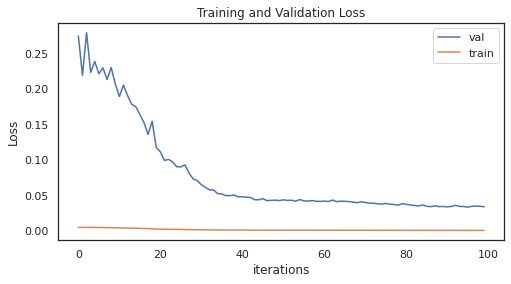

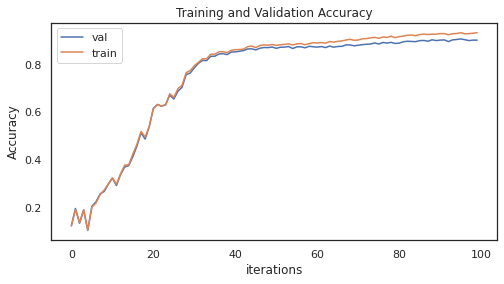

Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       980
           1       0.97      0.97      0.97      1135
           2       0.92      0.86      0.89      1032
           3       0.80      0.92      0.86      1010
           4       0.89      0.93      0.91       982
           5       0.86      0.82      0.84       892
           6       0.90      0.94      0.92       958
           7       0.95      0.91      0.93      1028
           8       0.87      0.84      0.86       974
           9       0.90      0.87      0.89      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



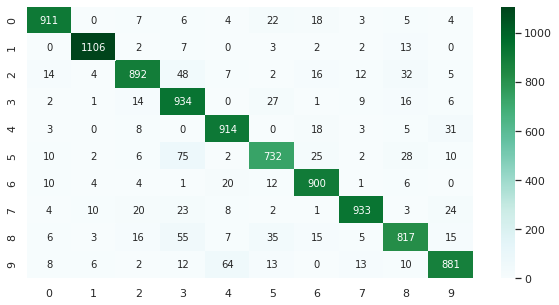

In [688]:
trainX = Train_ms_set_x_flatten
trainY = trainY                     
testX = Test_ms_set_x_flatten
testY = testY

model = Neural_Network(layers = 2, input_size = 784, no_of_neorons = [128, 64, 10], activation='sigmoid')
# try different combinations of epochs and learning rate
model.train(trainX, trainY, testX, testY, epochs = 100, learningRate = 0.005, batch_size = 50)

## without mean normalizaion 

0
training_accuracy = 0.10441666666666667, loss = 0.005574558939549103
validation_accuracy = 0.1028, loss = 0.26771674205525187
-------------------------------------------------------------------------------|
10
training_accuracy = 0.09035, loss = 0.0055759226298511995
validation_accuracy = 0.0892, loss = 0.3172507269601235
-------------------------------------------------------------------------------|
20
training_accuracy = 0.09915, loss = 0.00560424061562141
validation_accuracy = 0.1009, loss = 0.2772199393565965
-------------------------------------------------------------------------------|
30
training_accuracy = 0.09751666666666667, loss = 0.005624180376235844
validation_accuracy = 0.0974, loss = 0.2619490488864165
-------------------------------------------------------------------------------|
40
training_accuracy = 0.0993, loss = 0.0055713617046282944
validation_accuracy = 0.1032, loss = 0.2960434903883159
------------------------------------------------------------------------

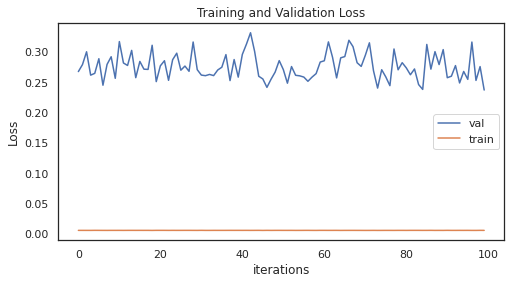

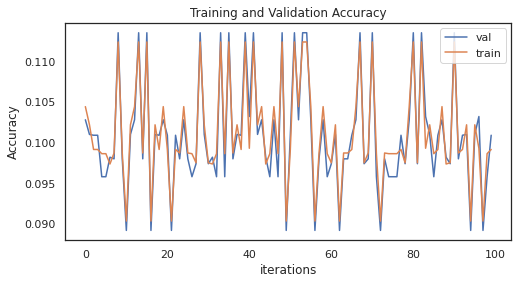

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Test Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.10      1.00      0.18      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



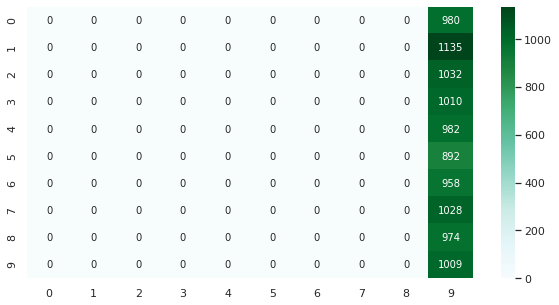

In [689]:
trainX = Train_set_x_flatten
trainY = trainY                     
testX = Test_set_x_flatten
testY = testY

model = Neural_Network(layers = 2, input_size = 784, no_of_neorons = [128, 64, 10], activation='sigmoid')
# try different combinations of epochs and learning rate
model.train(trainX, trainY, testX, testY, epochs = 100, learningRate = 0.005, batch_size = 50)

In [690]:
model.save('bestmodel_task3.mdl')

In [691]:
# create class object
mm = Neural_Network(layers = 2, input_size = 784, no_of_neorons = [128, 64, 10], activation='sigmoid')
# load model which will be provided by you
mm.load('bestmodel_task3.mdl')
# check accuracy of that model
mm.accuracy(testX,testY)

0.1009

In [692]:
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import plotly.graph_objects as go

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

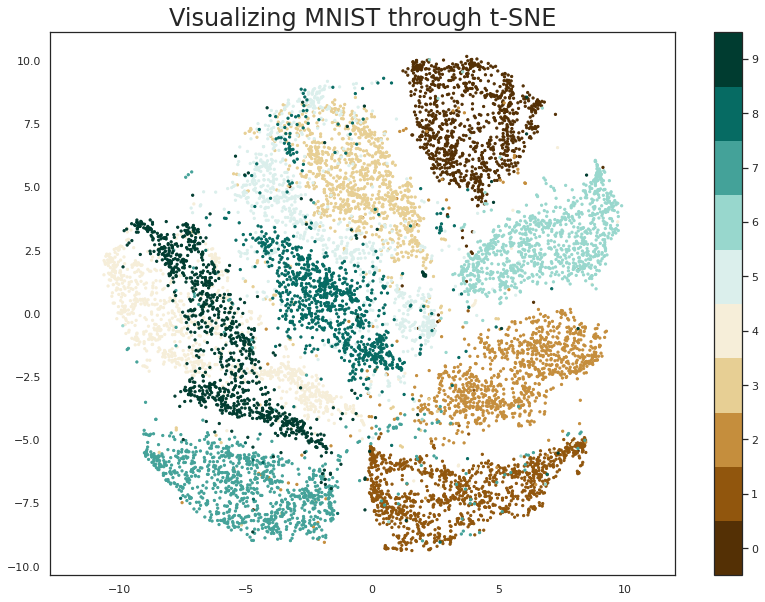

In [693]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(Test_ms_set_x_flatten)
plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=testY, cmap='BrBG')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizing MNIST through t-SNE', fontsize=24);